# **Visualise Class Imbalance**

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Heart_Disease
0    283883
1     24971
Name: count, dtype: int64


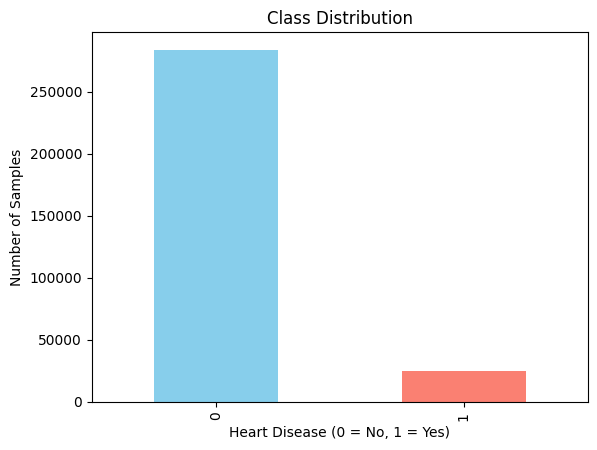

In [7]:
# Load the dataset
df = pd.read_csv('CVD_cleaned.csv')

# Encode all the categorical features using a LabelEncoder
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Check the class distribution of Heart_Disease
class_counts = df['Heart_Disease'].value_counts()
print(class_counts)

# Visualise the class imbalance of Heart_Disease
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Number of Samples')
plt.show()

#**Build, Train & Test your XGBoost Model**

In [8]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score

In [9]:
# Define the features (X) and the target (y)
X = df.drop(columns='Heart_Disease')
y = df['Heart_Disease']

# Split the data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost Classifier without class weighting
xgb = XGBClassifier(n_estimators=100, max_depth=6, eta=0.3)
xgb.fit(X_train, y_train)

# Predict the probabilities and the class labels
y_prob = xgb.predict_proba(X_test)
y_pred = xgb.predict(X_test)

# Calculate the loss and the accuracy
loss = log_loss(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)

# Print the loss and the accuracy
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.2%}')

Test Loss: 0.2245
Test Accuracy: 91.82%


In [16]:
# Add class weighting to help with class imbalance
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

# Train an XGBoost Classifier with class weighting
xgb_w = XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=100, max_depth=6, eta=0.3)
xgb_w.fit(X_train, y_train)

# Predict the probabilities and the class labels
y_prob_w = xgb_w.predict_proba(X_test)
y_pred_w = xgb_w.predict(X_test)

# Calculate the loss and the accuracy
loss_w = log_loss(y_test, y_prob_w)
accuracy_w = accuracy_score(y_test, y_pred_w)

# Print the loss and the accuracy
print(f'Test Loss: {loss_w:.4f}')
print(f'Test Accuracy: {accuracy_w:.2%}')

Test Loss: 0.4739
Test Accuracy: 74.44%


#**Plot Metrics**

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

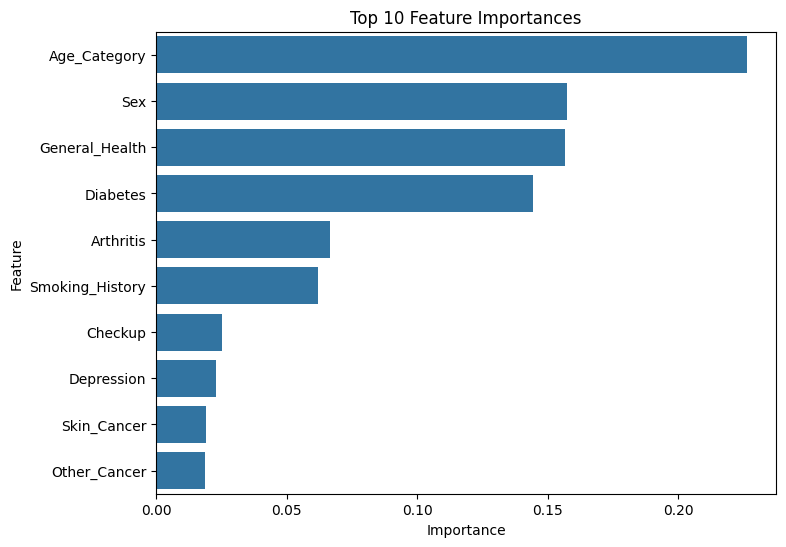

In [18]:
# Get the feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.show()

In [19]:
# Compute the precision, recall and F1-score of the model without class weighting
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Compute the precision, recall and F1-score of the model with class weighting
precision_w = precision_score(y_test, y_pred_w)
recall_w = recall_score(y_test, y_pred_w)
f1_w = f1_score(y_test, y_pred_w)

# Print the precision, recall and F1-score of both models
print('{:<25} {:>10} {:>10} {:>10}'.format('Model', 'Precision', 'Recall', 'F1-Score'))
print('-' * 60)
print('{:<25} {:>10.4f} {:>10.4f} {:>10.4f}'.format('Without Class Weighting', precision, recall, f1))
print('{:<25} {:>10.4f} {:>10.4f} {:>10.4f}'.format('With Class Weighting', precision_w, recall_w, f1_w))


Model                      Precision     Recall   F1-Score
------------------------------------------------------------
Without Class Weighting       0.4539     0.0532     0.0953
With Class Weighting          0.2073     0.7647     0.3262


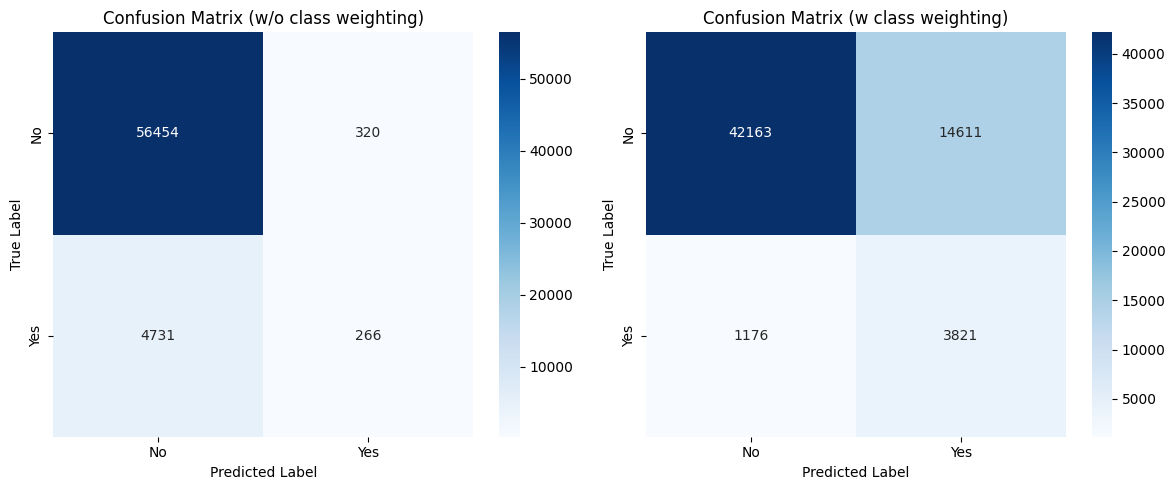

In [20]:
# Compute the confusion matrix of the model without class weighting
cm = confusion_matrix(y_test, y_pred)

# Compute the confusion matrix of the model with class weighting
cm_w = confusion_matrix(y_test, y_pred_w)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=axes[0])
axes[0].set_title('Confusion Matrix (w/o class weighting)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot the second confusion matrix
sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=axes[1])
axes[1].set_title('Confusion Matrix (w class weighting)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

#**Apply the Model**

In [24]:
# Load dataset for predictions
df_pred = pd.read_csv('CVD_cleaned.csv')
X_pred = df_pred.drop(columns=['Heart_Disease'])

# Encode all the categorical features using a LabelEncoder
label_encoders = {}
for col in X_pred.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_pred[col] = le.fit_transform(X_pred[col])
    label_encoders[col] = le

# Make predictions on the dataset
y_pred = xgb_w.predict(X_pred)

# Get the patient IDs (row indices in the dataset)
patient_ids = X_test.index

# Combine the patient IDs and the predictions + sort by patient ID
predictions = sorted(zip(patient_ids, y_pred))

# Print the predictions
print('Predictions:')
for patient_id, pred in predictions[:1000]:
    status = 'has heart disease' if pred == 1 else 'does not have heart disease'
    print(f'Patient {patient_id} {status}.')

Predictions:
Patient 0 has heart disease.
Patient 2 has heart disease.
Patient 6 does not have heart disease.
Patient 12 does not have heart disease.
Patient 16 has heart disease.
Patient 22 does not have heart disease.
Patient 24 does not have heart disease.
Patient 26 does not have heart disease.
Patient 30 has heart disease.
Patient 33 has heart disease.
Patient 41 does not have heart disease.
Patient 44 has heart disease.
Patient 49 has heart disease.
Patient 53 does not have heart disease.
Patient 79 does not have heart disease.
Patient 85 has heart disease.
Patient 87 does not have heart disease.
Patient 88 does not have heart disease.
Patient 89 does not have heart disease.
Patient 96 does not have heart disease.
Patient 106 has heart disease.
Patient 110 does not have heart disease.
Patient 117 has heart disease.
Patient 118 does not have heart disease.
Patient 119 has heart disease.
Patient 120 does not have heart disease.
Patient 123 does not have heart disease.
Patient 128 d